# An Automated Method for the Estimate of Vertical Jump Power through Intertial Measurement Units

This repository has been created as supplementary material/code source for the proceeding entitled *An Automated Method for the Estimate of Vertical Jump Power through Intertial Measurement Units* published for the $39^{\rm{th}}$ Conference of the International Society of Biomechanics in Sports (ISBS 2021). 

The aim of the study was to correct for IMU inaccuracies when trying to estimate concentric peak and mean power generated by a jumper during a vertical jump. The idea was to devise multiple linear regression models (MLRs) embedding both anthropometric and time-frequency parameters. 

In this Python Notebook you can find a brief example of the procedure applied to achieve a better power estimate by exploiting the MLR. The example provided here will take into account a sample Countermovement Jump, hence the following two MLRs apply:


|-| Constant ($b_0$) | $P_C$ ($b_1$) | $\overline{P}_C$ ($b_2$) | $P_E$ ($b_3$) | $\overline{P}_E$ ($b_4$) | B ($b_5$) | T ($b_6$) | S ($b_7$) | I  ($b_8$)| $P_\Delta$ ($b_9$) | $f_1$ ($b_{10}$) |
|-| ---------------- | ------------- | -------------------------| ------------- | ------------------------ | --------- | --------- | --------- | --------- | ------------------ | ---------------- |
| $MLR_{CMJ}^{P_C}$  |  10.40        | .47                      | .61           | -                        | -         |   -.24    | -         | -         | -.09               |    -     | -     | 
| $MLR_{CMJ}^{\overline{P}_C}$   |  9.2      | .16              | .2            | .14                      | 1.33         |   -.1    | -.08    | -.11         | -               |    -8.91     | -     | 


# Other resources
Notice that most of the signal processing have been alreadt made. To check how acceleration traces were processed (i.e. aligned with the world reference frame), please take a look to the other GitHub repository I made for a similar problem: **<a href = "https://github.com/Maskul93/MLR_ISB2021"> Smartphone-Based Democratization of Jump Height Estimate </a>**.

In [ ]:
## -- Load packages -- ##
import numpy as np                     # Array package
import pandas as pd                    # Data-Frame package
import math                            # "Basic Advanced" maths operations
import matplotlib.pyplot as plt        # Advanced plot tool
from scipy import integrate, signal    # Signal processing tool
import orient                          # Built-in orientation functions (from MLR_ISB2021 repo)

## -- Global variables -- ##
fs = 128                               # Sampling frequency for both systems
beta = .5                              # Complementary filter coefficient
g = 9.81                               # Gravitational acceleration [m/s^2]

In [ ]:
## -- Load the jump -- ##
x1 = pd.read_csv('./data/cmj_imu.csv')
x2 = pd.read_csv('./data/cmj_grf.csv')
grf = pd.DataFrame.to_numpy(x2[['grf']])    # Convert forceplate Ground Reaction Force into NumPy array
time = pd.DataFrame.to_numpy(x2[['time']])  # Convert time vector into NumPy array

## -- Convert accelerometer and gyroscope into NumPy arrays
acc_data = pd.DataFrame.to_numpy(x1[['ax','ay','az']])
gyr_data = pd.DataFrame.to_numpy(x1[['gx','gy','gz']])

r, p, y = orient.compl_filt(acc_data = acc_data, gyr_data = gyr_data, fs = fs, beta = beta)

q = orient.eul2quatern(r,p,y)    # Convert angles into a quaternion
a_glob = orient.align_to_WRF(q, acc_data)    # Align to WRF

## -- Get the acceleration (and the jumper mass) from GRF data
mass = np.mean(grf[0:99]) / g       # Compute mass from static phase
a_fp = ( grf / mass ) - g           # Get vertical acceleration

fig = plt.figure(1)
fig.dpi = 150
plt.plot(time, acc_data[:,1] - g)
plt.plot(time, a_glob)
plt.plot(time, a_fp)
plt.legend(['Raw acceleration', 'Aligned acceleration', 'FP-derived acceleration'])
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s$^2$)')

In [ ]:
## --- Apply VMD --- ##
from vmdpy import VMD
## --- VMD Parameters --- ##
alpha = 100        # Mid Bandwidth Constrain  
tau = 0            # Noise-tolerance (no strict fidelity enforcement)  
K = 3              # 3 IMFs  
DC = 0             # DC part not imposed  
init = 0           # Initialize omegas uniformly  
tol = 1e-20        # Tolerance parameter

time = np.linspace(0, a_glob.shape[0]/fs, num = a_glob.shape[0])

## --- Run VMD on smartphone aligned acceleration trace --- ## 
u, u_hat, omega = VMD(a_glob, alpha, tau, K, DC, init, tol)  
IMFs = np.transpose(u)

fig = plt.figure(1)
fig.dpi = 150
plt.plot(time, IMFs)
plt.xlabel('Time (s)'), plt.ylabel('Acceleration (m/s$^2$)'), plt.xlim([time[0], time[-1]])
plt.legend(['IMF$_1$', 'IMF$_2$', 'IMF$_3$'])

f3, f2, f1 = omega[-1] * ( fs / 2 )    # Convert the central-frequencies to their "actual value"
print("You got the following central frequencies:\n f1 = " + str(round(f1, 2)) + " [Hz]\n f2 = " + str(round(f2, 2)) + 
     " [Hz]\n f3 = " + str(round(f3, 2)) + " [Hz]")

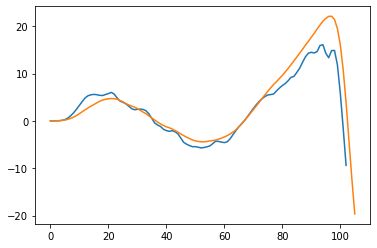

In [67]:
## -- Power computation -- ##
sb_imu, to_imu = 324, 427
sb_fp, to_fp = 323, 429

L_imu, L_fp = to_imu - sb_imu, to_fp - sb_fp    # Length of the acceleration to be considered
t_imu = np.linspace(0, L_imu/fs, num = L_imu)    # Create the linspace time vector for the integration
t_fp = np.linspace(0, L_fp/fs, num = L_fp)    # Create the linspace time vector for the integration
v_imu = integrate.cumtrapz(a_glob[sb_imu:to_imu], t_imu, initial=0)    # Perform the integration
v_fp = integrate.cumtrapz(a_fp[sb_fp:to_fp, 0], t_fp, initial=0)    # Perform the integration

# Compute Power P(t)
P_imu, P_fp = np.zeros(L_imu), np.zeros(L_fp)

for k in range(0, L_imu):
    P_imu[k] = a_glob[sb_imu + k] * v_imu[k]

for k in range(0, L_fp):
    P_fp[k] = a_fp[sb_fp + k] * v_fp[k]

plt.plot(P_imu)
plt.plot(P_fp)

(758,)